In [2]:
import os
import csv
import pandas as pd
import pprint as pp

# Adjust this directory for your local setup
mimic_dir = '/Users/vince/Documents/MIMIC/'
os.listdir(mimic_dir)

['.DS_Store', 'mimic-iv-note', 'mimic-iv-2.2']

In [95]:
mimic_note_dir = os.path.join(mimic_dir, 'mimic-iv-note/2.2/note')
mimic_icu_dir = os.path.join(mimic_dir, 'mimic-iv-2.2/icu')
mimic_hosp_dir = os.path.join(mimic_dir, 'mimic-iv-2.2/hosp')

### Dataset Construction

A subset of patients (10k at for now) will be used to create the initial dataset

The goal is to create chronological semi-structured journal entries for each patient

The LLM will be trained to output a sentiment score based on the current clinical data

Fine tuning can be accomplished based on discharge type. Some patients were sent to hospice or died, so sentiment should be negative.

Some lab results have the priority STAT which implies a dire situation. Abnormal range values will also be a key indicator of a health problem.



In [48]:
patients_df = pd.read_csv(mimic_hosp_dir + '/patients.csv')
patients_df.head()

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000068,F,19,2160,2008 - 2010,NaN
3,10000084,M,72,2160,2017 - 2019,2161-02-13
4,10000102,F,27,2136,2008 - 2010,NaN


In [214]:
patients_df.to_csv('data/patients_df.csv', index=False)

**Admissions** 

First merge patient gender and age into df

In [5]:
admissions_df = pd.read_csv(mimic_hosp_dir + '/admissions.csv')
admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])
admissions_df = pd.merge(admissions_df, patients_df[['subject_id', 'gender', 'anchor_age']], on='subject_id', how='left')
admissions_df.head()


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag,gender,anchor_age
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,F,52
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0,F,52
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,ENGLISH,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0,F,52
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,ENGLISH,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0,F,52
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,ENGLISH,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0,F,19


In [270]:
admissions_df['hadm_id'].isna().sum()

0

In [ ]:
admissions_df['subject_id'].unique().shape

**Diagnoses**

In [43]:
drgcodes_df = pd.read_csv(mimic_hosp_dir + '/drgcodes.csv')
drgcodes_df.head()

,subject_id,hadm_id,drg_type,drg_code,description,drg_severity,drg_mortality
0,10000032,22595853,APR,283,OTHER DISORDERS OF THE LIVER,2.0,2.0
1,10000032,22595853,HCFA,442,"DISORDERS OF LIVER EXCEPT MALIG,CIRR,ALC HEPA ...",NaN,NaN
2,10000032,22841357,APR,279,HEPATIC COMA & OTHER MAJOR ACUTE LIVER DISORDERS,3.0,2.0
3,10000032,22841357,HCFA,442,"DISORDERS OF LIVER EXCEPT MALIG,CIRR,ALC HEPA ...",NaN,NaN
4,10000032,25742920,APR,283,OTHER DISORDERS OF THE LIVER,3.0,2.0


In [42]:
drgcodes_df['description'].value_counts()[:20]

description
VAGINAL DELIVERY                                                      9882
HEART FAILURE                                                         8525
SEPTICEMIA & DISSEMINATED INFECTIONS                                  8217
ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC                7023
VAGINAL DELIVERY W/O COMPLICATING DIAGNOSES                           6899
PSYCHOSES                                                             5771
CESAREAN DELIVERY                                                     5440
OTHER PNEUMONIA                                                       5330
PERCUTANEOUS CORONARY INTERVENTION W/O AMI                            4616
KIDNEY & URINARY TRACT INFECTIONS                                     4396
SYNCOPE & COLLAPSE                                                    4311
CELLULITIS & OTHER SKIN INFECTIONS                                    4268
CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS                             4122
OTHER DIGESTI

In [60]:
# Identify the top 20 most common descriptions
top_20_descriptions = drgcodes_df['description'].value_counts().index[:20]

# Filter the dataframe to keep only rows with descriptions in the top 20
filtered_drgcodes_df = drgcodes_df[drgcodes_df['description'].isin(top_20_descriptions)]

# Display the first few rows of the filtered dataframe
filtered_drgcodes_df.head()

,subject_id,hadm_id,drg_type,drg_code,description,drg_severity,drg_mortality
7,10000032,29079034,HCFA,312,SYNCOPE & COLLAPSE,NaN,NaN
14,10000719,24558333,APR,560,VAGINAL DELIVERY,1.0,1.0
15,10000719,24558333,HCFA,775,VAGINAL DELIVERY W/O COMPLICATING DIAGNOSES,NaN,NaN
25,10000883,25221576,HCFA,885,PSYCHOSES,NaN,NaN
31,10000980,20897796,APR,194,HEART FAILURE,2.0,3.0


In [61]:
filtered_drgcodes_df['drg_severity'].fillna(0.0, inplace=True)
filtered_drgcodes_df['drg_mortality'].fillna(0.0, inplace=True)

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_57779/3986036321.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filtered_drgcodes_df['drg_severity'].fillna(0.0, inplace=True)
/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_57779/3986036321.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_drgcodes_df['drg_

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_57779/2470200671.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_drgcodes_df['description_truncated'] = filtered_drgcodes_df['description'].apply(lambda x: x[:20])


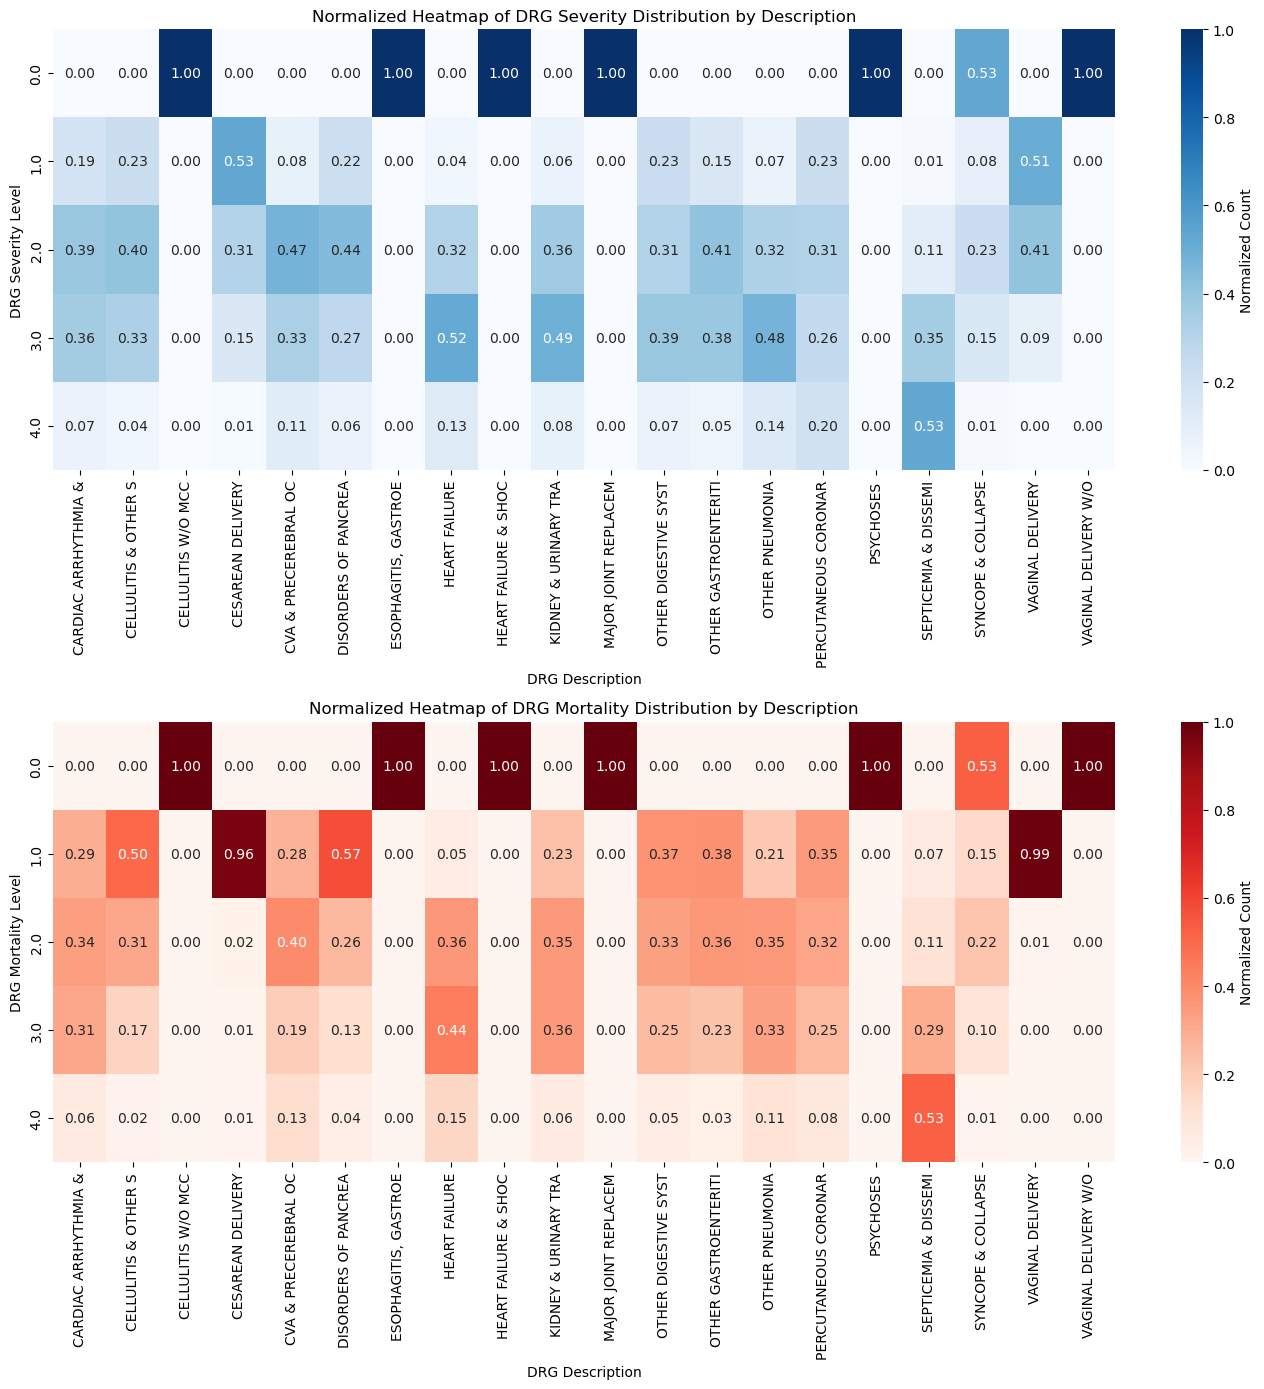

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Truncate descriptions to 20 characters
filtered_drgcodes_df['description_truncated'] = filtered_drgcodes_df['description'].apply(lambda x: x[:20])

# Create pivot tables to count occurrences of each severity and mortality level for each description
severity_counts = filtered_drgcodes_df.pivot_table(index='drg_severity', columns='description_truncated', aggfunc='size', fill_value=0)
mortality_counts = filtered_drgcodes_df.pivot_table(index='drg_mortality', columns='description_truncated', aggfunc='size', fill_value=0)

# Normalize the counts for each DRG code
severity_normalized = severity_counts.div(severity_counts.sum(axis=0), axis=1)
mortality_normalized = mortality_counts.div(mortality_counts.sum(axis=0), axis=1)

# Set up the matplotlib figure
fig, axes = plt.subplots(2, 1, figsize=(14, 14))

# Plot heatmap for normalized drg_severity
sns.heatmap(severity_normalized, ax=axes[0], annot=True, fmt=".2f", cmap="Blues", cbar_kws={'label': 'Normalized Count'})
axes[0].set_title('Normalized Heatmap of DRG Severity Distribution by Description')
axes[0].set_xlabel('DRG Description')
axes[0].set_ylabel('DRG Severity Level')

# Plot heatmap for normalized drg_mortality
sns.heatmap(mortality_normalized, ax=axes[1], annot=True, fmt=".2f", cmap="Reds", cbar_kws={'label': 'Normalized Count'})
axes[1].set_title('Normalized Heatmap of DRG Mortality Distribution by Description')
axes[1].set_xlabel('DRG Description')
axes[1].set_ylabel('DRG Mortality Level')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


In [70]:
filtered_drgcodes_df['drg_combined'] = filtered_drgcodes_df.apply(
    lambda row: (row['drg_severity'], row['drg_mortality']), axis=1
)

# Pivot table to consolidate DRG codes, severities, and mortalities for each hadm_id
pivot_df = filtered_drgcodes_df.pivot_table(
    index='hadm_id', 
    columns='description', 
    values='drg_combined', 
    aggfunc=lambda x: x if len(x) == 0 else list(x)[0]
)

# Flatten the multi-index columns
pivot_df.columns = [f'{col}_drg' for col in pivot_df.columns]

# Merge the pivot table with the admissions dataframe
merged_df = admissions_df.merge(pivot_df, on='hadm_id', how='left')

# Display the first few rows of the merged dataframe
merged_df.head()

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_57779/1993251973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_drgcodes_df['drg_combined'] = filtered_drgcodes_df.apply(


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC_drg,OTHER DIGESTIVE SYSTEM DIAGNOSES_drg,"OTHER GASTROENTERITIS, NAUSEA & VOMITING_drg",OTHER PNEUMONIA_drg,PERCUTANEOUS CORONARY INTERVENTION W/O AMI_drg,PSYCHOSES_drg,SEPTICEMIA & DISSEMINATED INFECTIONS_drg,SYNCOPE & COLLAPSE_drg,VAGINAL DELIVERY_drg,VAGINAL DELIVERY W/O COMPLICATING DIAGNOSES_drg
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P874LG,TRANSFER FROM HOSPITAL,HOME,Other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P09Q6Y,EMERGENCY ROOM,HOME,Medicaid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P60CC5,EMERGENCY ROOM,HOSPICE,Medicaid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P30KEH,EMERGENCY ROOM,HOME,Medicaid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(0.0, 0.0)",NaN,NaN
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P51VDL,EMERGENCY ROOM,NaN,Other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
merged_df.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag', 'gender',
       'anchor_age', 'CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS_drg',
       'CELLULITIS & OTHER SKIN INFECTIONS_drg', 'CELLULITIS W/O MCC_drg',
       'CESAREAN DELIVERY_drg', 'CVA & PRECEREBRAL OCCLUSION W INFARCT_drg',
       'DISORDERS OF PANCREAS EXCEPT MALIGNANCY_drg',
       'ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC_drg',
       'HEART FAILURE_drg', 'HEART FAILURE & SHOCK W MCC_drg',
       'KIDNEY & URINARY TRACT INFECTIONS_drg',
       'MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC_drg',
       'OTHER DIGESTIVE SYSTEM DIAGNOSES_drg',
       'OTHER GASTROENTERITIS, NAUSEA & VOMITING_drg', 'OTHER PNEUMONIA_drg',
       'PERCUTANEOUS CORONARY INTERVENTION W/O AMI_d

In [78]:
import pandas as pd

# Define the columns of interest
columns_of_interest = [
    'CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS_drg',
    'CELLULITIS & OTHER SKIN INFECTIONS_drg', 'CELLULITIS W/O MCC_drg',
    'CESAREAN DELIVERY_drg', 'CVA & PRECEREBRAL OCCLUSION W INFARCT_drg',
    'DISORDERS OF PANCREAS EXCEPT MALIGNANCY_drg',
    'ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC_drg',
    'HEART FAILURE_drg', 'HEART FAILURE & SHOCK W MCC_drg',
    'KIDNEY & URINARY TRACT INFECTIONS_drg',
    'MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC_drg',
    'OTHER DIGESTIVE SYSTEM DIAGNOSES_drg',
    'OTHER GASTROENTERITIS, NAUSEA & VOMITING_drg', 'OTHER PNEUMONIA_drg',
    'PERCUTANEOUS CORONARY INTERVENTION W/O AMI_drg', 'PSYCHOSES_drg',
    'SEPTICEMIA & DISSEMINATED INFECTIONS_drg', 'SYNCOPE & COLLAPSE_drg',
    'VAGINAL DELIVERY_drg', 'VAGINAL DELIVERY W/O COMPLICATING DIAGNOSES_drg'
]

# Create an empty DataFrame to store the sampled rows
sampled_df = pd.DataFrame()

# Iterate over the columns of interest and sample at least 1000 non-NaN rows for each
for col in columns_of_interest:
    non_nan_rows = merged_df[merged_df[col].notna()]
    sampled_rows = non_nan_rows.sample(n=1500, replace=True)
    sampled_df = pd.concat([sampled_df, sampled_rows])

# Drop duplicates to ensure unique rows
sampled_df = sampled_df.drop_duplicates()

# Display the first few rows of the sampled dataframe
sampled_df.head()


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC_drg,OTHER DIGESTIVE SYSTEM DIAGNOSES_drg,"OTHER GASTROENTERITIS, NAUSEA & VOMITING_drg",OTHER PNEUMONIA_drg,PERCUTANEOUS CORONARY INTERVENTION W/O AMI_drg,PSYCHOSES_drg,SEPTICEMIA & DISSEMINATED INFECTIONS_drg,SYNCOPE & COLLAPSE_drg,VAGINAL DELIVERY_drg,VAGINAL DELIVERY W/O COMPLICATING DIAGNOSES_drg
1231,10028480,22530994,2188-02-19 21:12:00,2188-02-24 17:00:00,NaN,EW EMER.,P886Y0,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196677,14566882,23136502,2173-09-05 21:32:00,2173-09-06 19:50:00,NaN,EW EMER.,P75OL3,EMERGENCY ROOM,HOME,Medicaid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
398254,19231624,20093354,2141-02-20 16:59:00,2141-02-27 17:29:00,NaN,OBSERVATION ADMIT,P0297D,PHYSICIAN REFERRAL,HOME,Other,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243450,15637048,29939663,2170-02-23 14:24:00,2170-02-24 15:39:00,NaN,EW EMER.,P27SDD,EMERGENCY ROOM,HOME,Medicare,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430622,19985885,25048461,2176-08-20 18:05:00,2176-08-23 13:30:00,NaN,EW EMER.,P558XI,EMERGENCY ROOM,HOME HEALTH CARE,Medicare,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
sampled_df.to_csv('data/sampled_df.csv', index=False)

In [87]:
admissions_df = sampled_df
admissions_df.shape

(24562, 38)

**Sample patients**

20000 unique hospital admissions

8579 unique patients

In [273]:
sample_patients = admissions_df['subject_id']

# Define a function to process chunks
def process_chunk(chunk):
    return chunk[chunk['subject_id'].isin(sample_patients)]

# Read and filter a large CSV in chunks
chunk_size = 10000  # Define a suitable chunk size

In [220]:
admissions_df['discharge_location'].value_counts()[:5]

discharge_location
HOME                        10194
HOME HEALTH CARE             4859
SKILLED NURSING FACILITY     2711
REHAB                         698
DIED                          580
Name: count, dtype: int64

In [88]:
admissions_df.to_csv('data/admissions_df.csv', index=False)

**Admissions Journal**

In [91]:

# Create the formatted text for journal entries
# Conceal information about final outcome

admissions_df['journal_text'] = (
    "Admission Type: " + admissions_df['admission_type'] +
    ", Admission Location: " + admissions_df['admission_location'] +
    ", Insurance: " + admissions_df['insurance'] +
    ", Language: " + admissions_df['language'] +
    ", Marital Status: " + admissions_df['marital_status'] +
    ", Race: " + admissions_df['race'] +
    ", Gender: " + admissions_df['gender'] +
    ", Age: " + admissions_df['anchor_age'].astype(str)
)

# Selecting relevant columns for the final DataFrame
admissions_journal_df = admissions_df[['subject_id', 'hadm_id', 'admittime', 'discharge_location', 'journal_text']]

# Renaming the 'journal_text' column for clarity
admissions_journal_df.rename(columns={'journal_text': 'text'}, inplace=True)

admissions_journal_df


/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_57779/2550859987.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admissions_journal_df.rename(columns={'journal_text': 'text'}, inplace=True)


,subject_id,hadm_id,admittime,discharge_location,text
1231,10028480,22530994,2188-02-19 21:12:00,HOME HEALTH CARE,"Admission Type: EW EMER., Admission Location: ..."
196677,14566882,23136502,2173-09-05 21:32:00,HOME,"Admission Type: EW EMER., Admission Location: ..."
398254,19231624,20093354,2141-02-20 16:59:00,HOME,"Admission Type: OBSERVATION ADMIT, Admission L..."
243450,15637048,29939663,2170-02-23 14:24:00,HOME,"Admission Type: EW EMER., Admission Location: ..."
430622,19985885,25048461,2176-08-20 18:05:00,HOME HEALTH CARE,"Admission Type: EW EMER., Admission Location: ..."
...,...,...,...,...,...
55281,11302621,29193924,2158-08-12 16:23:00,HOME,"Admission Type: URGENT, Admission Location: PH..."
95433,12241171,23450113,2120-01-21 06:07:00,HOME,"Admission Type: URGENT, Admission Location: PH..."
379970,18799490,27383748,2110-02-24 23:21:00,HOME,"Admission Type: URGENT, Admission Location: PH..."
288703,16701120,25619898,2128-03-09 17:37:00,HOME,"Admission Type: URGENT, Admission Location: PH..."


In [ ]:
admissions_journal_df.to_csv('data/admissions_journal_df.csv', index=False)

**Discharge**


In [96]:
sample_patients = admissions_df['hadm_id']

chunk_size = 10000

# Define a function to process chunks
def process_chunk(chunk):
    return chunk[chunk['hadm_id'].isin(sample_patients)]

chunks = pd.read_csv(mimic_note_dir + '/discharge.csv', chunksize=chunk_size)
filtered_chunks = [process_chunk(chunk) for chunk in chunks]
discharge_df = pd.concat(filtered_chunks, ignore_index=True)
discharge_df['charttime'] = pd.to_datetime(discharge_df['charttime'])
discharge_df['storetime'] = pd.to_datetime(discharge_df['storetime'])
discharge_df

,note_id,subject_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,10000980-DS-25,10000980,29659838,DS,25,2191-07-19,2191-07-22 09:37:00,\nName: ___ Unit No: ___\n \nAdmi...
1,10000980-DS-26,10000980,20897796,DS,26,2193-08-17,2193-08-17 16:05:00,\nName: ___ Unit No: ___\n \nAdmi...
2,10002013-DS-6,10002013,21975601,DS,6,2159-12-17,2159-12-21 10:02:00,\nName: ___ Unit No: ___\n...
3,10002155-DS-10,10002155,28994087,DS,10,2130-09-29,2130-10-01 16:46:00,\nName: ___ Unit No: ___\n...
4,10002430-DS-7,10002430,26295318,DS,7,2129-06-24,2129-06-24 16:51:00,\nName: ___ Unit No: ___\n \n...
...,...,...,...,...,...,...,...,...
20232,19997887-DS-4,19997887,25047276,DS,4,2117-04-09,2117-04-09 11:32:00,\nName: ___ Unit No: ___\n...
20233,19997911-DS-20,19997911,20274882,DS,20,2196-08-10,2196-08-12 23:14:00,\nName: ___ Unit No: ___\...
20234,19998497-DS-8,19998497,28129567,DS,8,2145-02-28,2145-02-28 14:55:00,\nName: ___ Unit No: ___\n \...
20235,19999625-DS-12,19999625,27638769,DS,12,2138-10-09,2138-10-10 01:42:00,\nName: ___ Unit No: ___\n \n...


In [100]:
# Perform the merge operation
discharge_merged_df = discharge_df.merge(admissions_df, on='hadm_id', how='left')

# Display the first few rows of the merged dataframe
discharge_merged_df

,note_id,subject_id_x,hadm_id,note_type,note_seq,charttime,storetime,text,subject_id_y,admittime,...,OTHER DIGESTIVE SYSTEM DIAGNOSES_drg,"OTHER GASTROENTERITIS, NAUSEA & VOMITING_drg",OTHER PNEUMONIA_drg,PERCUTANEOUS CORONARY INTERVENTION W/O AMI_drg,PSYCHOSES_drg,SEPTICEMIA & DISSEMINATED INFECTIONS_drg,SYNCOPE & COLLAPSE_drg,VAGINAL DELIVERY_drg,VAGINAL DELIVERY W/O COMPLICATING DIAGNOSES_drg,journal_text
0,10000980-DS-25,10000980,29659838,DS,25,2191-07-19,2191-07-22 09:37:00,\nName: ___ Unit No: ___\n \nAdmi...,10000980,2191-07-16 14:21:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Admission Type: EW EMER., Admission Location: ..."
1,10000980-DS-26,10000980,20897796,DS,26,2193-08-17,2193-08-17 16:05:00,\nName: ___ Unit No: ___\n \nAdmi...,10000980,2193-08-15 01:01:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Admission Type: OBSERVATION ADMIT, Admission L..."
2,10002013-DS-6,10002013,21975601,DS,6,2159-12-17,2159-12-21 10:02:00,\nName: ___ Unit No: ___\n...,10002013,2159-12-14 23:55:00,...,NaN,NaN,NaN,"(3.0, 2.0)",NaN,NaN,NaN,NaN,NaN,"Admission Type: EW EMER., Admission Location: ..."
3,10002155-DS-10,10002155,28994087,DS,10,2130-09-29,2130-10-01 16:46:00,\nName: ___ Unit No: ___\n...,10002155,2130-09-23 21:59:00,...,NaN,NaN,"(3.0, 4.0)",NaN,NaN,NaN,NaN,NaN,NaN,"Admission Type: EW EMER., Admission Location: ..."
4,10002430-DS-7,10002430,26295318,DS,7,2129-06-24,2129-06-24 16:51:00,\nName: ___ Unit No: ___\n \n...,10002430,2129-06-13 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Admission Type: URGENT, Admission Location: TR..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20232,19997887-DS-4,19997887,25047276,DS,4,2117-04-09,2117-04-09 11:32:00,\nName: ___ Unit No: ___\n...,19997887,2117-04-07 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Admission Type: SURGICAL SAME DAY ADMISSION, A..."
20233,19997911-DS-20,19997911,20274882,DS,20,2196-08-10,2196-08-12 23:14:00,\nName: ___ Unit No: ___\...,19997911,2196-08-08 05:44:00,...,"(4.0, 3.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Admission Type: OBSERVATION ADMIT, Admission L..."
20234,19998497-DS-8,19998497,28129567,DS,8,2145-02-28,2145-02-28 14:55:00,\nName: ___ Unit No: ___\n \...,19998497,2145-02-25 12:06:00,...,NaN,NaN,NaN,"(2.0, 2.0)",NaN,NaN,NaN,NaN,NaN,"Admission Type: URGENT, Admission Location: PH..."
20235,19999625-DS-12,19999625,27638769,DS,12,2138-10-09,2138-10-10 01:42:00,\nName: ___ Unit No: ___\n \n...,19999625,2138-10-06 17:27:00,...,NaN,NaN,"(3.0, 4.0)",NaN,NaN,NaN,NaN,NaN,NaN,"Admission Type: EW EMER., Admission Location: ..."


In [102]:
discharge_merged_df['disch_journal_text'] = (
    discharge_merged_df['journal_text'] + ' ' + discharge_merged_df['text']
)

discharge_merged_df['disch_journal_text'].iloc[0]

"Admission Type: EW EMER., Admission Location: EMERGENCY ROOM, Insurance: Medicare, Language: ENGLISH, Marital Status: MARRIED, Race: BLACK/AFRICAN AMERICAN, Gender: F, Age: 73  \nName:  ___          Unit No:   ___\n \nAdmission Date:  ___              Discharge Date:   ___\n \nDate of Birth:  ___             Sex:   F\n \nService: MEDICINE\n \nAllergies: \nNo Known Allergies / Adverse Drug Reactions\n \nAttending: ___.\n \nChief Complaint:\ndyspnea on exertion\n \nMajor Surgical or Invasive Procedure:\nNone\n\n \nHistory of Present Illness:\n___ with a history of of HTN, CAD s/p DES with ischemic MR and \nsystolic dysfunction, ___ on torsemide, hx of DVT, who presents \nwith 4 days of dyspnea on exertion, leg swelling, and 10 weight \ngain.\n\nOf note, patient was seen in the Heart Failure Clinic with Dr. \n___ on ___ where she noted that she has had \npersistent dyspnea on exertion and PND after a lengthy prior \nhospitalization for DVT/GIB. At that time she was started on \n40mg po t

In [106]:
short_names = {
    'CARDIAC ARRHYTHMIA & CONDUCTION DISORDERS_drg': 'CARD_ARRHYTHMIA',
    'CELLULITIS & OTHER SKIN INFECTIONS_drg': 'CELL_SKIN_INF',
    'CELLULITIS W/O MCC_drg': 'CELL_NO_MCC',
    'CESAREAN DELIVERY_drg': 'CESAREAN',
    'CVA & PRECEREBRAL OCCLUSION W INFARCT_drg': 'CVA_INFARCT',
    'DISORDERS OF PANCREAS EXCEPT MALIGNANCY_drg': 'PANCREAS_DIS',
    'ESOPHAGITIS, GASTROENT & MISC DIGEST DISORDERS W/O MCC_drg': 'DIGEST_DIS_NO_MCC',
    'HEART FAILURE_drg': 'HEART_FAILURE',
    'HEART FAILURE & SHOCK W MCC_drg': 'HEART_SHOCK_MCC',
    'KIDNEY & URINARY TRACT INFECTIONS_drg': 'KIDNEY_UTI',
    'MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC_drg': 'JOINT_REPLACE_NO_MCC',
    'OTHER DIGESTIVE SYSTEM DIAGNOSES_drg': 'DIGEST_DIS_OTHER',
    'OTHER GASTROENTERITIS, NAUSEA & VOMITING_drg': 'GASTRO_NAUSEA',
    'OTHER PNEUMONIA_drg': 'PNEUMONIA_OTHER',
    'PERCUTANEOUS CORONARY INTERVENTION W/O AMI_drg': 'PCI_NO_AMI',
    'PSYCHOSES_drg': 'PSYCHOSES',
    'SEPTICEMIA & DISSEMINATED INFECTIONS_drg': 'SEPTICEMIA',
    'SYNCOPE & COLLAPSE_drg': 'SYNCOPE',
    'VAGINAL DELIVERY_drg': 'VAG_DELIVERY',
    'VAGINAL DELIVERY W/O COMPLICATING DIAGNOSES_drg': 'VAG_DEL_NO_COMPL'
}

# Rename the columns in the dataframe
discharge_merged_df.rename(columns=short_names, inplace=True)

discharge_merged_df.columns

Index(['note_id', 'subject_id_x', 'hadm_id', 'note_type', 'note_seq',
       'charttime', 'storetime', 'text', 'subject_id_y', 'admittime',
       'dischtime', 'deathtime', 'admission_type', 'admit_provider_id',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'marital_status', 'race', 'edregtime', 'edouttime',
       'hospital_expire_flag', 'gender', 'anchor_age', 'CARD_ARRHYTHMIA',
       'CELL_SKIN_INF', 'CELL_NO_MCC', 'CESAREAN', 'CVA_INFARCT',
       'PANCREAS_DIS', 'DIGEST_DIS_NO_MCC', 'HEART_FAILURE', 'HEART_SHOCK_MCC',
       'KIDNEY_UTI', 'JOINT_REPLACE_NO_MCC', 'DIGEST_DIS_OTHER',
       'GASTRO_NAUSEA', 'PNEUMONIA_OTHER', 'PCI_NO_AMI', 'PSYCHOSES',
       'SEPTICEMIA', 'SYNCOPE', 'VAG_DELIVERY', 'VAG_DEL_NO_COMPL',
       'journal_text', 'disch_journal_text'],
      dtype='object')

In [113]:
columns_to_binarize = [
    'CARD_ARRHYTHMIA', 'CELL_SKIN_INF', 'CELL_NO_MCC', 'CESAREAN', 'CVA_INFARCT',
    'PANCREAS_DIS', 'DIGEST_DIS_NO_MCC', 'HEART_FAILURE', 'HEART_SHOCK_MCC', 'KIDNEY_UTI',
    'JOINT_REPLACE_NO_MCC', 'DIGEST_DIS_OTHER', 'GASTRO_NAUSEA', 'PNEUMONIA_OTHER',
    'PCI_NO_AMI', 'PSYCHOSES', 'SEPTICEMIA', 'SYNCOPE', 'VAG_DELIVERY', 'VAG_DEL_NO_COMPL'
]

# Binarize each column
for col in columns_to_binarize:
    discharge_merged_df[f'{col}'] = discharge_merged_df[col].apply(lambda x: 0 if pd.isna(x) else 1)


In [116]:
discharge_merged_df.columns

Index(['note_id', 'subject_id_x', 'hadm_id', 'note_type', 'note_seq',
       'charttime', 'storetime', 'text', 'subject_id_y', 'admittime',
       'dischtime', 'deathtime', 'admission_type', 'admit_provider_id',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'marital_status', 'race', 'edregtime', 'edouttime',
       'hospital_expire_flag', 'gender', 'anchor_age', 'CARD_ARRHYTHMIA',
       'CELL_SKIN_INF', 'CELL_NO_MCC', 'CESAREAN', 'CVA_INFARCT',
       'PANCREAS_DIS', 'DIGEST_DIS_NO_MCC', 'HEART_FAILURE', 'HEART_SHOCK_MCC',
       'KIDNEY_UTI', 'JOINT_REPLACE_NO_MCC', 'DIGEST_DIS_OTHER',
       'GASTRO_NAUSEA', 'PNEUMONIA_OTHER', 'PCI_NO_AMI', 'PSYCHOSES',
       'SEPTICEMIA', 'SYNCOPE', 'VAG_DELIVERY', 'VAG_DEL_NO_COMPL',
       'journal_text', 'disch_journal_text'],
      dtype='object')

In [117]:
columns_to_keep = ['hadm_id', 'discharge_location'] + columns_to_binarize + ['disch_journal_text']

discharge_merged_df_filtered =  discharge_merged_df[columns_to_keep]
discharge_merged_df_filtered

,hadm_id,discharge_location,CARD_ARRHYTHMIA,CELL_SKIN_INF,CELL_NO_MCC,CESAREAN,CVA_INFARCT,PANCREAS_DIS,DIGEST_DIS_NO_MCC,HEART_FAILURE,...,DIGEST_DIS_OTHER,GASTRO_NAUSEA,PNEUMONIA_OTHER,PCI_NO_AMI,PSYCHOSES,SEPTICEMIA,SYNCOPE,VAG_DELIVERY,VAG_DEL_NO_COMPL,disch_journal_text
0,29659838,HOME HEALTH CARE,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"Admission Type: EW EMER., Admission Location: ..."
1,20897796,HOME HEALTH CARE,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"Admission Type: OBSERVATION ADMIT, Admission L..."
2,21975601,HOME,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,"Admission Type: EW EMER., Admission Location: ..."
3,28994087,HOME HEALTH CARE,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"Admission Type: EW EMER., Admission Location: ..."
4,26295318,SKILLED NURSING FACILITY,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"Admission Type: URGENT, Admission Location: TR..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20232,25047276,HOME HEALTH CARE,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"Admission Type: SURGICAL SAME DAY ADMISSION, A..."
20233,20274882,HOME,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,"Admission Type: OBSERVATION ADMIT, Admission L..."
20234,28129567,HOME,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,"Admission Type: URGENT, Admission Location: PH..."
20235,27638769,HOME HEALTH CARE,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,"Admission Type: EW EMER., Admission Location: ..."


In [118]:
from pprint import pprint
pprint(discharge_merged_df_filtered['disch_journal_text'].iloc[0])

('Admission Type: EW EMER., Admission Location: EMERGENCY ROOM, Insurance: '
 'Medicare, Language: ENGLISH, Marital Status: MARRIED, Race: BLACK/AFRICAN '
 'AMERICAN, Gender: F, Age: 73  \n'
 'Name:  ___          Unit No:   ___\n'
 ' \n'
 'Admission Date:  ___              Discharge Date:   ___\n'
 ' \n'
 'Date of Birth:  ___             Sex:   F\n'
 ' \n'
 'Service: MEDICINE\n'
 ' \n'
 'Allergies: \n'
 'No Known Allergies / Adverse Drug Reactions\n'
 ' \n'
 'Attending: ___.\n'
 ' \n'
 'Chief Complaint:\n'
 'dyspnea on exertion\n'
 ' \n'
 'Major Surgical or Invasive Procedure:\n'
 'None\n'
 '\n'
 ' \n'
 'History of Present Illness:\n'
 '___ with a history of of HTN, CAD s/p DES with ischemic MR and \n'
 'systolic dysfunction, ___ on torsemide, hx of DVT, who presents \n'
 'with 4 days of dyspnea on exertion, leg swelling, and 10 weight \n'
 'gain.\n'
 '\n'
 'Of note, patient was seen in the Heart Failure Clinic with Dr. \n'
 '___ on ___ where she noted that she has had \n'
 'persistent

In [119]:
discharge_merged_df_filtered.to_csv('data/discharge_merged_df.csv', index=False)

In [337]:
discharge_df['charttime'] = pd.to_datetime(discharge_df['charttime'])

# Create the formatted text for journal entries
discharge_df['journal_text'] = (
    "Subject ID: " + discharge_df['subject_id'].astype(str) +
    ", HAdm ID: " + discharge_df['hadm_id'].astype(str) +
    ", Chart Time: " + discharge_df['charttime'].dt.strftime('%Y-%m-%d %H:%M:%S') +
    "\n\n" + discharge_df['text']
)

# Selecting relevant columns for the final DataFrame
discharge_journal_df = discharge_df[['note_id', 'subject_id', 'hadm_id', 'charttime', 'journal_text']]

# Renaming the 'journal_text' column for clarity
discharge_journal_df.rename(columns={'journal_text': 'text'}, inplace=True)

# Display the DataFrame to verify the results
discharge_journal_df

/var/folders/dv/lndb9rrs2kv2v5g8cyfyx0wr0000gn/T/ipykernel_31606/2659453306.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discharge_journal_df.rename(columns={'journal_text': 'text'}, inplace=True)


,note_id,subject_id,hadm_id,charttime,text
0,10000032-DS-21,10000032,22595853,2180-05-07,"Subject ID: 10000032, HAdm ID: 22595853, Chart..."
1,10000032-DS-22,10000032,22841357,2180-06-27,"Subject ID: 10000032, HAdm ID: 22841357, Chart..."
2,10000032-DS-23,10000032,29079034,2180-07-25,"Subject ID: 10000032, HAdm ID: 29079034, Chart..."
3,10000032-DS-24,10000032,25742920,2180-08-07,"Subject ID: 10000032, HAdm ID: 25742920, Chart..."
4,10000084-DS-17,10000084,23052089,2160-11-25,"Subject ID: 10000084, HAdm ID: 23052089, Chart..."
...,...,...,...,...,...
15223,10486120-DS-3,10486120,21496368,2113-11-03,"Subject ID: 10486120, HAdm ID: 21496368, Chart..."
15224,10486130-DS-15,10486130,25382870,2148-09-18,"Subject ID: 10486130, HAdm ID: 25382870, Chart..."
15225,10486144-DS-25,10486144,21214054,2124-04-06,"Subject ID: 10486144, HAdm ID: 21214054, Chart..."
15226,10486144-DS-26,10486144,28877892,2124-07-14,"Subject ID: 10486144, HAdm ID: 28877892, Chart..."


In [339]:
import pprint as pp 
pp.pprint(discharge_journal_df.iloc[0].text)

('Subject ID: 10000032, HAdm ID: 22595853, Chart Time: 2180-05-07 00:00:00\n'
 '\n'
 ' \n'
 'Name:  ___                     Unit No:   ___\n'
 ' \n'
 'Admission Date:  ___              Discharge Date:   ___\n'
 ' \n'
 'Date of Birth:  ___             Sex:   F\n'
 ' \n'
 'Service: MEDICINE\n'
 ' \n'
 'Allergies: \n'
 'No Known Allergies / Adverse Drug Reactions\n'
 ' \n'
 'Attending: ___\n'
 ' \n'
 'Chief Complaint:\n'
 'Worsening ABD distension and pain \n'
 ' \n'
 'Major Surgical or Invasive Procedure:\n'
 'Paracentesis\n'
 '\n'
 ' \n'
 'History of Present Illness:\n'
 '___ HCV cirrhosis c/b ascites, hiv on ART, h/o IVDU, COPD, \n'
 'bioplar, PTSD, presented from OSH ED with worsening abd \n'
 'distension over past week.  \n'
 'Pt reports self-discontinuing lasix and spirnolactone ___ weeks \n'
 'ago, because she feels like "they don\'t do anything" and that \n'
 'she "doesn\'t want to put more chemicals in her." She does not \n'
 'follow Na-restricted diets. In the past week, she not

In [340]:
discharge_journal_df.to_csv('data/discharge_journal_df.csv', index=False)

In [343]:
admissions_df.discharge_location.value_counts()

discharge_location
HOME                            7186
HOME HEALTH CARE                3499
SKILLED NURSING FACILITY        1922
REHAB                            501
DIED                             412
CHRONIC/LONG TERM ACUTE CARE     330
HOSPICE                          149
AGAINST ADVICE                   141
PSYCH FACILITY                   101
ACUTE HOSPITAL                    74
OTHER FACILITY                    54
ASSISTED LIVING                   29
HEALTHCARE FACILITY                4
Name: count, dtype: int64